# Golden Cross Strategy — Tunable, Multi‑Signal Confirmations, and Optimizer

This notebook extends a classic **Golden Cross** strategy (short SMA crossing above long SMA) with **configurable confirmations** (MACD, RSI, ADX, StochRSI, CCI, Slope filter, Volume filter) and a **built‑in parameter optimizer**.

**What you get:**
- Pure‑Python indicator implementations (no TA‑Lib requirement)
- Configurable confirmations with `CONFIRMATION_MODE`: `'all'`, `'any'`, `'k-of-n'`
- Flexible exits: death cross, ATR trailing stop, fixed SL/TP, and max-hold days
- Objective selection to **maximize return** or **minimize loss** (e.g., max CAGR, max Sharpe/Sortino, min MaxDD)
- Random-search tuner over defined parameter ranges (no external services required)
- Exports detailed **signals** and **trades** CSVs for auditing

> Tip: Start with fewer tickers and smaller date ranges to iterate faster; then expand.


Great question. You already have everything you need: per-ticker **best params**, **confirm mode (k-of-n)**, and both **per-ticker** (`confirmations_hit`) and **per-trade** (`confirmations_true`) diagnostics. Here’s how to turn that into a clean, tradable system.

# 1) Define the strategy (daily timeframe, EOD execution)

**Core idea:** Golden-Cross (SMA\_short crosses above SMA\_long) + **k-of-n confirmations**.
**Exit:** Death-cross OR take-profit OR stop-loss OR max-hold (and ATR trail if enabled).

Concretely, for each ticker:

* **Entry:** On day *t* if

  * `SMA_short[t-1] <= SMA_long[t-1]` and `SMA_short[t] > SMA_long[t]` (bullish cross), and
  * at least `confirm_k` of the specified confirmations evaluate **True** on day *t* (e.g., RSI in band, MACD>signal, ADX≥min, SRSI K>D & below upper, CCI≥min, SMA slope up, Volume percentile≥min).
  * **Execute** at next day open (*t+1*).
* **Exit (first hit wins):**

  * **TP:** `High/entry_px - 1 ≥ take_profit_pct`
  * **SL:** `Low/entry_px - 1 ≤ -stop_loss_pct` (if not null)
  * **Death-cross:** `SMA_short` crosses **below** `SMA_long`
  * **Max-hold:** `bars_in_trade ≥ max_hold`
  * **ATR trail (if use\_atr\_trail)**: exit if `Close < (highest_close_since_entry - atr_mult*ATR)`

# 2) Choose *which* tickers to trade

Two practical approaches:

* **Per-ticker specialization**: Use each ticker’s own row from `gc_all_params.csv`. Trade top N by `score` (e.g., top 10 CAGR).
* **One “global” template**: Take the **median** of the params from your top decile and apply to all tickers for simplicity and stability.

Rebalance/refresh this selection **monthly** or **quarterly** (walk-forward).

# 3) Risk & position sizing (simple + robust)

* **Risk per trade**: 0.5–1.0% of portfolio.
* **ATR-based sizing**: `shares = floor( (risk_amount) / (atr_mult * ATR[t]) )`
* **Max exposure**: cap open positions (e.g., 10–15) and/or sector caps (e.g., 20% per sector).
* **Costs/slippage (NSE)**: include STT, brokerage, stamp, GST, SEBI fee, impact (e.g., 8–15 bps round-trip) in backtests.

# 4) Validation (avoid overfitting)

* **Walk-forward**:

  * Train/optimize on window A (e.g., 2015–2022), **lock** params, trade on B (2023–2024), finally report OOS on 2025.
* **Hold-out / Purge** edges: keep a gap between train/test around regime shifts.
* **Stress**: bear/bull regimes, high-vol episodes; make sure results don’t vanish with small cost/slippage changes.

# 5) Daily workflow (automation)

1. After market close, compute indicators for your universe.
2. For each ticker’s **locked** params, check GC + confirmations (k-of-n).
3. Generate **orders** for next open sized by ATR/risk.
4. Track trades and exits with the same rules.
5. Log everything; produce dashboards for WinRate, MaxDD, exposure, sector weight, etc.

---

## Minimal code template (drop-in)

This snippet uses **your CSV outputs** and runs the rules above. Replace data feed with yours.

```python
import pandas as pd
import numpy as np

# --- Load your chosen params (e.g., top 10 by CAGR) ---
params_df = pd.read_csv("gc_all_params.csv")
universe = (params_df
            .sort_values("CAGR", ascending=False)
            .head(10))  # top N tickers by score/CAGR

# --- Helper to evaluate k-of-n confirmations on a row ---
def passes_confirmations(row, p):
    names = ["MACD","RSI","ADX","STOCHRSI","CCI","SLOPE","VOLUME"]
    checks = {
        "MACD":      row["MACD"] > row["MACDsig"],
        "RSI":       (row["RSI"] >= p["rsi_buy_min"]) and (row["RSI"] <= p["rsi_buy_max"]),
        "ADX":       row["ADX"] >= p["adx_min"],
        "STOCHRSI":  (row["SRSI_K"] > row["SRSI_D"]) and (row["SRSI_K"] < p["srsi_upper"]),
        "CCI":       row["CCI"] >= p["cci_min"],
        "SLOPE":     row["SMA_short"] > row["SMA_short_prev_win"],
        "VOLUME":    row["VolPctRank"] >= p["vol_pct_min"],
    }
    names_true = [n for n in names if checks.get(n, False)]
    k = int(p["confirm_k"])
    return len(names_true) >= k, names_true

# --- Example: apply to one ticker's DataFrame `df` already with indicators ---
# df must have: Open, High, Low, Close, Volume, SMA_short/long, MACD/MACDsig, RSI, ADX, SRSI_K/D, CCI, ATR
# plus helpers: SMA_short_prev_win, VolPctRank (percentile in last p["vol_rank_win"] bars)

def run_strategy_on_df(df, p, costs_bps=10):
    df = df.copy()
    # Crosses
    df["gc_up"] = (df["SMA_short"].shift(1) <= df["SMA_long"].shift(1)) & (df["SMA_short"] > df["SMA_long"])
    df["dc_down"] = (df["SMA_short"].shift(1) >= df["SMA_long"].shift(1)) & (df["SMA_short"] < df["SMA_long"])

    # Entry scan
    trades = []
    in_pos = False
    entry_px = None
    entry_bar = None
    entry_conf = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        if not in_pos and row["gc_up"]:
            ok, names_true = passes_confirmations(row, p)
            if ok:
                # enter at next open if exists, else close
                px = df["Open"].iloc[i+1] if i+1 < len(df) else row["Close"]
                entry_px = float(px)
                entry_bar = i
                entry_conf = names_true
                in_pos = True

        if in_pos:
            exit_reasons = []
            # TP/SL
            if p["take_profit_pct"] is not None:
                if (df["High"].iloc[i] / entry_px - 1.0) >= p["take_profit_pct"]:
                    exit_reasons.append("TP")
            if p["stop_loss_pct"] is not None:
                if (df["Low"].iloc[i] / entry_px - 1.0) <= -abs(p["stop_loss_pct"]):
                    exit_reasons.append("SL")
            # Death cross
            if df["dc_down"].iloc[i]:
                exit_reasons.append("DeathCross")
            # Max hold
            if (i - entry_bar) >= int(p["max_hold"]):
                exit_reasons.append("MaxHold")
            # ATR trail (optional)
            if p.get("use_atr_trail"):
                # simplistic: trail from highest close since entry
                highest = df["Close"].iloc[entry_bar:i+1].max()
                trail = highest - p["atr_mult"] * df["ATR"].iloc[i]
                if df["Close"].iloc[i] < trail:
                    exit_reasons.append("ATRTrail")

            if exit_reasons:
                px = df["Open"].iloc[i+1] if i+1 < len(df) else df["Close"].iloc[i]
                gross_ret = (float(px) / entry_px - 1.0)
                # subtract round-trip costs
                net_ret = gross_ret - (costs_bps/1e4)*2
                trades.append({
                    "entry_idx": entry_bar,
                    "exit_idx": i,
                    "entry_date": df.index[entry_bar],
                    "exit_date": df.index[i],
                    "entry_px": entry_px,
                    "exit_px": float(px),
                    "ret": net_ret,
                    "exit_reason": "+".join(exit_reasons),
                    "confirmations_true": "|".join(entry_conf),
                })
                in_pos = False

    return pd.DataFrame(trades)
```

> Use the **exact per-ticker hyperparameters** from `gc_all_params.csv` (or your curated global set). For live trading you must evaluate **daily** confirmations on the **entry bar**; do **not** rely on `confirmations_hit` (that’s just a summary/diagnostic).

---

## Turning it live (practical, low-friction)

* **Nightly job (cron/CI):** pull EOD data → compute indicators → create signals & orders for next open → log CSVs.
* **Broker API (paper first):** place orders at 9:15 IST using your risk sizer; respect max exposure & caps.
* **Monitoring:** daily P/L, exposure, VaR, drawdown; weekly refit (if you choose walk-forward re-optimization).

If you want, I can:

* Generate a **clean notebook** that takes `gc_all_params.csv`, fetches data, **executes the exact live rules**, and saves **orders.csv** daily.
* Add **portfolio sizing** (ATR risk parity, max concurrent positions) + **transaction cost model** tuned for NSE.


In [12]:
# =========================
# Configuration
# =========================
TICKERS = ['360ONE.NS', '3MINDIA.NS', 'ABB.NS', 'ACC.NS', 'ACMESOLAR.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AWL.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABREL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AFCONS.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'AKUMS.NS', 'APLLTD.NS', 'ALIVUS.NS', 'ALKEM.NS', 'ALKYLAMINE.NS', 'ALOKINDS.NS', 'ARE&M.NS', 'AMBER.NS', 'AMBUJACEM.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APARINDS.NS', 'APOLLOHOSP.NS', 'APOLLOTYRE.NS', 'APTUS.NS', 'ASAHIINDIA.NS', 'ASHOKLEY.NS', 'ASIANPAINT.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ASTRAL.NS', 'ATUL.NS', 'AUROPHARMA.NS', 'AIIL.NS', 'DMART.NS', 'AXISBANK.NS', 'BASF.NS', 'BEML.NS', 'BLS.NS', 'BSE.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BALKRISIND.NS', 'BALRAMCHIN.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BATAINDIA.NS', 'BAYERCROP.NS', 'BERGEPAINT.NS', 'BDL.NS', 'BEL.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BHARTIHEXA.NS', 'BIKAJI.NS', 'BIOCON.NS', 'BSOFT.NS', 'BLUEDART.NS', 'BLUESTARCO.NS', 'BBTC.NS', 'BOSCHLTD.NS', 'FIRSTCRY.NS', 'BRIGADE.NS', 'BRITANNIA.NS', 'MAPMYINDIA.NS', 'CCL.NS', 'CESC.NS', 'CGPOWER.NS', 'CRISIL.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CANBK.NS', 'CAPLIPOINT.NS', 'CGCL.NS', 'CARBORUNIV.NS', 'CASTROLIND.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYPLY.NS', 'CERA.NS', 'CHALET.NS', 'CHAMBLFERT.NS', 'CHENNPETRO.NS', 'CHOLAHLDNG.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'CUB.NS', 'CLEAN.NS', 'COALINDIA.NS', 'COCHINSHIP.NS', 'COFORGE.NS', 'COHANCE.NS', 'COLPAL.NS', 'CAMS.NS', 'CONCORDBIO.NS', 'CONCOR.NS', 'COROMANDEL.NS', 'CRAFTSMAN.NS', 'CREDITACC.NS', 'CROMPTON.NS', 'CUMMINSIND.NS', 'CYIENT.NS', 'DCMSHRIRAM.NS', 'DLF.NS', 'DOMS.NS', 'DABUR.NS', 'DALBHARAT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'DEEPAKNTR.NS', 'DELHIVERY.NS', 'DEVYANI.NS', 'DIVISLAB.NS', 'DIXON.NS', 'LALPATHLAB.NS', 'DRREDDY.NS', 'EIDPARRY.NS', 'EIHOTEL.NS', 'EICHERMOT.NS', 'ELECON.NS', 'ELGIEQUIP.NS', 'EMAMILTD.NS', 'EMCURE.NS', 'ENDURANCE.NS', 'ENGINERSIN.NS', 'ERIS.NS', 'ESCORTS.NS', 'ETERNAL.NS', 'EXIDEIND.NS', 'NYKAA.NS', 'FEDERALBNK.NS', 'FACT.NS', 'FINCABLES.NS', 'FINPIPE.NS', 'FSL.NS', 'FIVESTAR.NS', 'FORTIS.NS', 'GAIL.NS', 'GVT&D.NS', 'GMRAIRPORT.NS', 'GRSE.NS', 'GICRE.NS', 'GILLETTE.NS', 'GLAND.NS', 'GLAXO.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GODIGIT.NS', 'GPIL.NS', 'GODFRYPHLP.NS', 'GODREJAGRO.NS', 'GODREJCP.NS', 'GODREJIND.NS', 'GODREJPROP.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GRASIM.NS', 'GRAVITA.NS', 'GESHIP.NS', 'FLUOROCHEM.NS', 'GUJGASLTD.NS', 'GMDCLTD.NS', 'GNFC.NS', 'GPPL.NS', 'GSPL.NS', 'HEG.NS', 'HBLENGINE.NS', 'HCLTECH.NS', 'HDFCAMC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS', 'HSCL.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDCOPPER.NS', 'HINDPETRO.NS', 'HINDUNILVR.NS', 'HINDZINC.NS', 'POWERINDIA.NS', 'HOMEFIRST.NS', 'HONASA.NS', 'HONAUT.NS', 'HUDCO.NS', 'HYUNDAI.NS', 'ICICIBANK.NS', 'ICICIGI.NS', 'ICICIPRULI.NS', 'IDBI.NS', 'IDFCFIRSTB.NS', 'IFCI.NS', 'IIFL.NS', 'INOXINDIA.NS', 'IRB.NS', 'IRCON.NS', 'ITC.NS', 'ITI.NS', 'INDGN.NS', 'INDIACEM.NS', 'INDIAMART.NS', 'INDIANB.NS', 'IEX.NS', 'INDHOTEL.NS', 'IOC.NS', 'IOB.NS', 'IRCTC.NS', 'IRFC.NS', 'IREDA.NS', 'IGL.NS', 'INDUSTOWER.NS', 'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INOXWIND.NS', 'INTELLECT.NS', 'INDIGO.NS', 'IGIL.NS', 'IKS.NS', 'IPCALAB.NS', 'JBCHEPHARM.NS', 'JKCEMENT.NS', 'JBMA.NS', 'JKTYRE.NS', 'JMFINANCIL.NS', 'JSWENERGY.NS', 'JSWHL.NS', 'JSWINFRA.NS', 'JSWSTEEL.NS', 'JPPOWER.NS', 'J&KBANK.NS', 'JINDALSAW.NS', 'JSL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'JUBLFOOD.NS', 'JUBLINGREA.NS', 'JUBLPHARMA.NS', 'JWL.NS', 'JUSTDIAL.NS', 'JYOTHYLAB.NS', 'JYOTICNC.NS', 'KPRMILL.NS', 'KEI.NS', 'KNRCON.NS', 'KPITTECH.NS', 'KAJARIACER.NS', 'KPIL.NS', 'KALYANKJIL.NS', 'KANSAINER.NS', 'KARURVYSYA.NS', 'KAYNES.NS', 'KEC.NS', 'KFINTECH.NS', 'KIRLOSBROS.NS', 'KIRLOSENG.NS', 'KOTAKBANK.NS', 'KIMS.NS', 'LTF.NS', 'LTTS.NS', 'LICHSGFIN.NS', 'LTFOODS.NS', 'LTIM.NS', 'LT.NS', 'LATENTVIEW.NS', 'LAURUSLABS.NS', 'LEMONTREE.NS', 'LICI.NS', 'LINDEINDIA.NS', 'LLOYDSME.NS', 'LODHA.NS', 'LUPIN.NS', 'MMTC.NS', 'MRF.NS', 'MGL.NS', 'MAHSEAMLES.NS', 'M&MFIN.NS', 'M&M.NS', 'MANAPPURAM.NS', 'MRPL.NS', 'MANKIND.NS', 'MARICO.NS', 'MARUTI.NS', 'MASTEK.NS', 'MFSL.NS', 'MAXHEALTH.NS', 'MAZDOCK.NS', 'METROPOLIS.NS', 'MINDACORP.NS', 'MSUMI.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MCX.NS', 'MUTHOOTFIN.NS', 'NATCOPHARM.NS', 'NBCC.NS', 'NCC.NS', 'NHPC.NS', 'NLCINDIA.NS', 'NMDC.NS', 'NSLNISP.NS', 'NTPCGREEN.NS', 'NTPC.NS', 'NH.NS', 'NATIONALUM.NS', 'NAVA.NS', 'NAVINFLUOR.NS', 'NESTLEIND.NS', 'NETWEB.NS', 'NETWORK18.NS', 'NEULANDLAB.NS', 'NEWGEN.NS', 'NAM-INDIA.NS', 'NIVABUPA.NS', 'NUVAMA.NS', 'OBEROIRLTY.NS', 'ONGC.NS', 'OIL.NS', 'OLAELEC.NS', 'OLECTRA.NS', 'PAYTM.NS', 'OFSS.NS', 'POLICYBZR.NS', 'PCBL.NS', 'PGEL.NS', 'PIIND.NS', 'PNBHOUSING.NS', 'PNCINFRA.NS', 'PTCIL.NS', 'PVRINOX.NS', 'PAGEIND.NS', 'PATANJALI.NS', 'PERSISTENT.NS', 'PETRONET.NS', 'PFIZER.NS', 'PHOENIXLTD.NS', 'PIDILITIND.NS', 'PEL.NS', 'PPLPHARMA.NS', 'POLYMED.NS', 'POLYCAB.NS', 'POONAWALLA.NS', 'PFC.NS', 'POWERGRID.NS', 'PRAJIND.NS', 'PREMIERENE.NS', 'PRESTIGE.NS', 'PNB.NS', 'RRKABEL.NS', 'RBLBANK.NS', 'RECLTD.NS', 'RHIM.NS', 'RITES.NS', 'RADICO.NS', 'RVNL.NS', 'RAILTEL.NS', 'RAINBOW.NS', 'RKFORGE.NS', 'RCF.NS', 'RTNINDIA.NS', 'RAYMONDLSL.NS', 'RAYMOND.NS', 'REDINGTON.NS', 'RELIANCE.NS', 'RPOWER.NS', 'ROUTE.NS', 'SBFC.NS', 'SBICARD.NS', 'SBILIFE.NS', 'SJVN.NS', 'SKFINDIA.NS', 'SRF.NS', 'SAGILITY.NS', 'SAILIFE.NS', 'SAMMAANCAP.NS', 'MOTHERSON.NS', 'SAPPHIRE.NS', 'SARDAEN.NS', 'SAREGAMA.NS', 'SCHAEFFLER.NS', 'SCHNEIDER.NS', 'SCI.NS', 'SHREECEM.NS', 'RENUKA.NS', 'SHRIRAMFIN.NS', 'SHYAMMETL.NS', 'SIEMENS.NS', 'SIGNATURE.NS', 'SOBHA.NS', 'SOLARINDS.NS', 'SONACOMS.NS', 'SONATSOFTW.NS', 'STARHEALTH.NS', 'SBIN.NS', 'SAIL.NS', 'SWSOLAR.NS', 'SUMICHEM.NS', 'SUNPHARMA.NS', 'SUNTV.NS', 'SUNDARMFIN.NS', 'SUNDRMFAST.NS', 'SUPREMEIND.NS', 'SUZLON.NS', 'SWANCORP.NS', 'SWIGGY.NS', 'SYNGENE.NS', 'SYRMA.NS', 'TBOTEK.NS', 'TVSMOTOR.NS', 'TANLA.NS', 'TATACHEM.NS', 'TATACOMM.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAELXSI.NS', 'TATAINVEST.NS', 'TATAMOTORS.NS', 'TATAPOWER.NS', 'TATASTEEL.NS', 'TATATECH.NS', 'TTML.NS', 'TECHM.NS', 'TECHNOE.NS', 'TEJASNET.NS', 'NIACL.NS', 'RAMCOCEM.NS', 'THERMAX.NS', 'TIMKEN.NS', 'TITAGARH.NS', 'TITAN.NS', 'TORNTPHARM.NS', 'TORNTPOWER.NS', 'TARIL.NS', 'TRENT.NS', 'TRIDENT.NS', 'TRIVENI.NS', 'TRITURBINE.NS', 'TIINDIA.NS', 'UCOBANK.NS', 'UNOMINDA.NS', 'UPL.NS', 'UTIAMC.NS', 'ULTRACEMCO.NS', 'UNIONBANK.NS', 'UBL.NS', 'UNITDSPR.NS', 'USHAMART.NS', 'VGUARD.NS', 'DBREALTY.NS', 'VTL.NS', 'VBL.NS', 'MANYAVAR.NS', 'VEDL.NS', 'VIJAYA.NS', 'VMM.NS', 'IDEA.NS', 'VOLTAS.NS', 'WAAREEENER.NS', 'WELCORP.NS', 'WELSPUNLIV.NS', 'WESTLIFE.NS', 'WHIRLPOOL.NS', 'WIPRO.NS', 'WOCKPHARMA.NS', 'YESBANK.NS', 'ZFCVINDIA.NS', 'ZEEL.NS', 'ZENTEC.NS', 'ZENSARTECH.NS', 'ZYDUSLIFE.NS', 'ECLERX.NS']

DATE_START = "2019-01-01"
DATE_END   = None  # None -> up to today

# Objective for tuning: one of {"cagr", "sharpe", "sortino", "min_maxdd"}
OPT_OBJECTIVE = "cagr"

# Number of random trials for optimization
N_TRIALS = 150

# Confirmation configuration
CONFIRMATION_TYPE = ["MACD", "RSI", "ADX", "STOCHRSI", "CCI", "SLOPE", "VOLUME"]
CONFIRMATION_MODE = "k-of-n"  # {"all", "any", "k-of-n"}
CONFIRMATION_MIN  = 2         # used only when mode == "k-of-n"

# Backtest / costs
START_CAPITAL = 100_000.0
BROKER_FEE_BP = 5.0           # basis points per trade (0.05%)
SLIPPAGE_BP   = 2.0           # basis points per executed side (0.02%)
RISK_FREE_RATE = 0.05         # for Sharpe/Sortino annualization

# Reproducibility
SEED = 42

# Output files
OUTPUT_DIR = "output"
OUT_SIGNALS_CSV = f"{OUTPUT_DIR}/gc_signals_optimized.csv"
OUT_TRADES_CSV  = f"{OUTPUT_DIR}/gc_trades_optimized.csv"
OUT_BEST_JSON   = f"{OUTPUT_DIR}/gc_best_params.json"
import os; os.makedirs(OUTPUT_DIR, exist_ok=True)


In [13]:
import warnings, math, random, os, json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# Install yfinance if missing (works only when you run the notebook with internet)
try:
    import yfinance as yf
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "yfinance"])
    import yfinance as yf

random.seed(SEED)
np.random.seed(SEED)

def annualize_return(total_ret, days):
    if days <= 0:
        return 0.0
    years = days / 252.0
    return (1 + total_ret) ** (1/years) - 1 if years > 0 else 0.0

def drawdown_stats(equity_curve):
    # equity_curve is a pandas Series of equity values
    peak = equity_curve.cummax()
    dd = (equity_curve / peak) - 1.0
    max_dd = dd.min()
    return max_dd, dd

def sharpe_ratio(returns, rf=0.0, periods_per_year=252):
    # returns: daily returns series
    excess = returns - rf/periods_per_year
    mu = excess.mean()
    sigma = excess.std(ddof=1)
    if sigma == 0 or np.isnan(sigma):
        return 0.0
    return (mu / sigma) * np.sqrt(periods_per_year)

def sortino_ratio(returns, rf=0.0, periods_per_year=252):
    excess = returns - rf/periods_per_year
    downside = excess[excess < 0]
    dd_sigma = downside.std(ddof=1)
    mu = excess.mean()
    if dd_sigma == 0 or np.isnan(dd_sigma):
        return 0.0
    return (mu / dd_sigma) * np.sqrt(periods_per_year)

def slope(series, window=5):
    # simple rolling slope via linear fit on index vs values
    idx = np.arange(window)
    def _s(x):
        y = x.values
        if len(y) < window:
            return np.nan
        # slope of least-squares fit
        num = (idx - idx.mean()) @ (y - y.mean())
        den = ((idx - idx.mean())**2).sum()
        return num/den if den != 0 else 0.0
    return series.rolling(window).apply(_s, raw=False)

def pct_rank(s, window):
    return s.rolling(window).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=False)


In [14]:
# =========================
# Data Download (daily)
# =========================
if DATE_END is None:
    end = datetime.today().strftime("%Y-%m-%d")
else:
    end = DATE_END

data = {}
for t in TICKERS:
    df = yf.download(t, start=DATE_START, end=end, progress=False, auto_adjust=False, multi_level_index=False)
    if df.empty:
        print(f"[WARN] No data for {t}")
        continue
    # Keep both raw and adjusted close for flexibility
    df = df.rename(columns=str.title)
    data[t] = df.dropna().copy()

print(f"Downloaded {len(data)} tickers with data.")


Downloaded 500 tickers with data.


In [15]:
# =========================
# Indicator Engineering (pure pandas/numpy)
# =========================
def SMA(s, n):
    return s.rolling(n).mean()

def EMA(s, n):
    return s.ewm(span=n, adjust=False).mean()

def RSI(s, n=14):
    delta = s.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/n, adjust=False).mean()
    roll_down = down.ewm(alpha=1/n, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100 / (1 + rs))

def MACD_line(s, fast=12, slow=26):
    return EMA(s, fast) - EMA(s, slow)

def MACD_signal(macd, signal=9):
    return EMA(macd, signal)

def TrueRange(high, low, close):
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    return tr

def ATR(high, low, close, n=14):
    tr = TrueRange(high, low, close)
    return tr.ewm(alpha=1/n, adjust=False).mean()

def DI(high, low, close, n=14):
    up_move = high.diff()
    down_move = -low.diff()
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    tr = TrueRange(high, low, close)
    atr = tr.ewm(alpha=1/n, adjust=False).mean()
    plus_di = 100 * pd.Series(plus_dm, index=high.index).ewm(alpha=1/n, adjust=False).mean() / (atr + 1e-12)
    minus_di = 100 * pd.Series(minus_dm, index=high.index).ewm(alpha=1/n, adjust=False).mean() / (atr + 1e-12)
    return plus_di, minus_di

def ADX(high, low, close, n=14):
    plus_di, minus_di = DI(high, low, close, n=n)
    dx = ( (plus_di - minus_di).abs() / (plus_di + minus_di + 1e-12) ) * 100
    adx = dx.ewm(alpha=1/n, adjust=False).mean()
    return adx, plus_di, minus_di

def StochRSI(close, rsi_n=14, stoch_n=14, k=3, d=3):
    rsi = RSI(close, n=rsi_n)
    min_rsi = rsi.rolling(stoch_n).min()
    max_rsi = rsi.rolling(stoch_n).max()
    stoch = 100 * (rsi - min_rsi) / ( (max_rsi - min_rsi) + 1e-12 )
    k_line = stoch.rolling(k).mean()
    d_line = k_line.rolling(d).mean()
    return k_line, d_line, rsi

def CCI(high, low, close, n=20):
    tp = (high + low + close) / 3.0
    sma = tp.rolling(n).mean()
    md = (tp - sma).abs().rolling(n).mean()
    return (tp - sma) / (0.015 * (md + 1e-12))

def enrich(df, p):
    # p: dict of parameters
    close = df["Close"]
    high  = df["High"]
    low   = df["Low"]
    vol   = df.get("Volume")

    df["SMA_S"] = SMA(close, p["sma_short"])
    df["SMA_L"] = SMA(close, p["sma_long"])
    df["GC"]    = (df["SMA_S"] > df["SMA_L"]) & (df["SMA_S"].shift(1) <= df["SMA_L"].shift(1))

    # Trend slope (optional confirmation)
    df["SLOPE_L"] = slope(df["SMA_L"], p["slope_win"])

    # MACD
    df["MACD"]  = MACD_line(close, fast=p["macd_fast"], slow=p["macd_slow"])
    df["MACDs"] = MACD_signal(df["MACD"], p["macd_signal"])
    df["MACDh"] = df["MACD"] - df["MACDs"]

    # RSI
    df["RSI"] = RSI(close, n=p["rsi_n"])

    # ADX
    adx, pdi, mdi = ADX(high, low, close, n=p["adx_n"])
    df["ADX"] = adx
    df["+DI"] = pdi
    df["-DI"] = mdi

    # StochRSI
    k, d, rsi_for_stoch = StochRSI(close, rsi_n=p["srsi_rsi_n"], stoch_n=p["srsi_stoch_n"], k=p["srsi_k"], d=p["srsi_d"])
    df["SRSI_K"] = k
    df["SRSI_D"] = d

    # CCI
    df["CCI"] = CCI(high, low, close, n=p["cci_n"])

    # ATR for stops
    df["ATR"] = ATR(high, low, close, n=p["atr_n"])

    # Volume rank (optional)
    if vol is not None:
        df["VOL_PCT"] = pct_rank(vol.fillna(0), p["vol_rank_win"])
    else:
        df["VOL_PCT"] = np.nan

    return df


In [16]:
# =========================
# Confirmations and Backtest
# =========================
def confirmations_row(row, p):
    votes = []
    if "MACD" in p["confirmations"]:
        votes.append(row["MACDh"] > 0)
    if "RSI" in p["confirmations"]:
        votes.append((row["RSI"] > p["rsi_buy_min"]) & (row["RSI"] < p["rsi_buy_max"]))
    if "ADX" in p["confirmations"]:
        votes.append((row["ADX"] >= p["adx_min"]) & (row["+DI"] > row["-DI"]))
    if "STOCHRSI" in p["confirmations"]:
        votes.append( (row["SRSI_K"] > row["SRSI_D"]) & (row["SRSI_K"] < p["srsi_upper"]) )
    if "CCI" in p["confirmations"]:
        votes.append(row["CCI"] > p["cci_min"])
    if "SLOPE" in p["confirmations"]:
        votes.append(row["SLOPE_L"] > 0)
    if "VOLUME" in p["confirmations"] and not math.isnan(row.get("VOL_PCT", np.nan)):
        votes.append(row["VOL_PCT"] >= p["vol_pct_min"])

    if p["confirm_mode"] == "all":
        return all(votes) if votes else True
    elif p["confirm_mode"] == "any":
        return any(votes) if votes else True
    elif p["confirm_mode"] == "k-of-n":
        k = p["confirm_k"]
        return (sum(bool(v) for v in votes) >= k) if votes else True
    else:
        return True

def generate_signals(df, p):
    df = df.copy()
    df["CONFIRM"] = df.apply(lambda r: confirmations_row(r, p), axis=1)
    df["ENTRY"] = df["GC"] & df["CONFIRM"]
    # death cross for exit
    df["DC"] = (df["SMA_S"] < df["SMA_L"]) & (df["SMA_S"].shift(1) >= df["SMA_L"].shift(1))
    return df

def backtest(df, p, fees_bp=5.0, slippage_bp=2.0, start_capital=100_000.0):
    # Full-capital single-position backtester (one position at a time per ticker)
    # Entry on next day's open after ENTRY signal, exit on next open after exit condition
    capital = start_capital
    position = 0  # shares
    entry_px = None
    shares = 0
    equity = []
    trades = []
    in_pos = False
    hold_days = 0

    for i in range(1, len(df)):  # start from 1 to access prev row
        today = df.index[i]
        yday  = df.index[i-1]

        open_px = df["Open"].iloc[i]
        high_px = df["High"].iloc[i]
        low_px  = df["Low"].iloc[i]
        close_px= df["Close"].iloc[i]
        atr     = df["ATR"].iloc[i]

        # Evaluate exits if in position
        exit_reason = None
        if in_pos:
            hold_days += 1
            # ATR trailing stop
            if p["use_atr_trail"]:
                trail = entry_px - p["atr_mult"] * atr
                if low_px < trail:
                    exit_reason = "ATR_trail"
            # Fixed stop-loss/take-profit intraday checks
            if exit_reason is None and p["stop_loss_pct"] is not None:
                if low_px <= entry_px * (1 - p["stop_loss_pct"]):
                    exit_reason = "SL_hit"
            if exit_reason is None and p["take_profit_pct"] is not None:
                if high_px >= entry_px * (1 + p["take_profit_pct"]):
                    exit_reason = "TP_hit"
            # Death cross
            if exit_reason is None and df["DC"].iloc[i]:
                exit_reason = "DeathCross"
            # Max hold
            if exit_reason is None and hold_days >= p["max_hold"]:
                exit_reason = "MaxHold"

        # Execute exit at next open (i+1) if reason set at i
        if in_pos and exit_reason is not None and i+1 < len(df):
            nxt_open = df["Open"].iloc[i+1]
            # apply slippage both sides of trade
            exec_px = nxt_open * (1 - slippage_bp/10000.0)
            # sell
            gross = shares * exec_px
            fee = gross * (fees_bp/10000.0)
            capital = gross - fee
            pnl = (exec_px - entry_px) * shares - fee  # fee only on exit here; entry fee applied at entry
            trades.append({
                "entry_time": entry_time,
                "exit_time": df.index[i+1],
                "side": "LONG",
                "entry_price": entry_px,
                "exit_price": exec_px,
                "reason": exit_reason,
                "bars": hold_days,
                "gross_ret_pct": (exec_px/entry_px - 1)*100.0,
                "pnl": pnl,
                "equity_after": capital
            })
            in_pos = False
            position = 0
            shares = 0
            entry_px = None
            hold_days = 0

        # Evaluate entries (if flat)
        if (not in_pos) and df["ENTRY"].iloc[i-1]:
            # enter at today's open (current i)
            exec_px = open_px * (1 + slippage_bp/10000.0)
            # use full capital
            fee = capital * (fees_bp/10000.0)
            deploy = capital - fee
            shares = int(deploy // exec_px)
            if shares > 0:
                spent = shares * exec_px
                capital = deploy - spent  # leftover
                entry_px = exec_px
                entry_time = today
                in_pos = True
                position = shares

        # Daily equity (mark-to-market if in position)
        mark_value = capital
        if in_pos and shares > 0:
            mark_value += shares * close_px
        equity.append(mark_value)

    equity = pd.Series(equity, index=df.index[1:])
    # daily returns
    rets = equity.pct_change().fillna(0.0)
    max_dd, dd_series = drawdown_stats(equity)
    total_ret = equity.iloc[-1]/equity.iloc[0] - 1 if len(equity) > 1 else 0.0
    cagr = annualize_return(total_ret, len(equity))

    metrics = {
        "total_return": float(total_ret),
        "CAGR": float(cagr),
        "Sharpe": float(sharpe_ratio(rets, rf=RISK_FREE_RATE)),
        "Sortino": float(sortino_ratio(rets, rf=RISK_FREE_RATE)),
        "MaxDD": float(max_dd),
        "WinRate": float(np.mean([1 if t["pnl"]>0 else 0 for t in trades]) if trades else 0.0),
        "NumTrades": int(len(trades))
    }
    trades_df = pd.DataFrame(trades)
    return equity, rets, metrics, trades_df


In [17]:
# =========================
# Random Search Optimizer
# =========================
def sample_params():
    # Define sensible ranges
    sma_long = random.randint(150, 260)
    sma_short = random.randint(20, 80)
    if sma_short >= sma_long:
        sma_short = max(10, sma_long - random.randint(30, 60))

    p = {
        "sma_short": sma_short,
        "sma_long": sma_long,
        "slope_win": random.randint(5, 20),

        "macd_fast": random.randint(8, 15),
        "macd_slow": random.randint(20, 30),
        "macd_signal": random.randint(6, 12),

        "rsi_n": random.randint(8, 20),
        "rsi_buy_min": random.randint(35, 48),
        "rsi_buy_max": random.randint(55, 65),

        "adx_n": random.randint(10, 20),
        "adx_min": random.randint(15, 30),

        "srsi_rsi_n": random.randint(10, 20),
        "srsi_stoch_n": random.randint(10, 20),
        "srsi_k": random.randint(3, 5),
        "srsi_d": random.randint(3, 5),
        "srsi_upper": random.randint(60, 85),

        "cci_n": random.randint(14, 30),
        "cci_min": random.randint(-50, 50),

        "atr_n": random.randint(10, 20),
        "vol_rank_win": random.randint(20, 60),
        "vol_pct_min": random.uniform(0.5, 0.9),

        "use_atr_trail": random.choice([True, False]),
        "atr_mult": round(random.uniform(1.0, 4.0), 2),

        "stop_loss_pct": random.choice([None, 0.03, 0.04, 0.05, 0.06]),
        "take_profit_pct": random.choice([None, 0.06, 0.08, 0.10, 0.12]),
        "max_hold": random.randint(10, 60),

        "confirmations": CONFIRMATION_TYPE.copy(),
        "confirm_mode": CONFIRMATION_MODE,
        "confirm_k": CONFIRMATION_MIN,
    }
    return p

def objective_score(metrics, objective="cagr"):
    if objective == "cagr":
        return metrics["CAGR"]
    elif objective == "sharpe":
        return metrics["Sharpe"]
    elif objective == "sortino":
        return metrics["Sortino"]
    elif objective == "min_maxdd":
        # turn into a maximization by negating drawdown
        return -abs(metrics["MaxDD"])
    else:
        return metrics["CAGR"]

def tune_params_for_ticker(df, objective="cagr", n_trials=100):
    best = None
    best_score = -1e18
    best_metrics = None
    for _ in range(n_trials):
        p = sample_params()
        edf = enrich(df.copy(), p)
        sig = generate_signals(edf, p)
        equity, rets, metrics, trades = backtest(sig, p, fees_bp=BROKER_FEE_BP, slippage_bp=SLIPPAGE_BP, start_capital=START_CAPITAL)
        score = objective_score(metrics, objective=objective)
        if score > best_score:
            best_score = score
            best = p
            best_metrics = metrics
    return best, best_metrics, best_score


In [18]:
# =========================
# Run Optimization
# =========================
results = []
best_overall = None
best_overall_score = -1e18
best_overall_metrics = None
best_ticker = None

for t, df in data.items():
    print(f"Tuning for {t} ...")
    best_p, best_m, best_s = tune_params_for_ticker(df, objective=OPT_OBJECTIVE, n_trials=N_TRIALS)
    results.append({"ticker": t, "best_score": best_s, "best_metrics": best_m, "params": best_p})
    if best_s > best_overall_score:
        best_overall_score = best_s
        best_overall = best_p
        best_overall_metrics = best_m
        best_ticker = t

print("==== Best Overall ====")
print("Ticker:", best_ticker)
print("Score:", best_overall_score)
print("Metrics:", best_overall_metrics)
with open(OUT_BEST_JSON, "w") as f:
    json.dump({
        "best_ticker": best_ticker,
        "best_score": best_overall_score,
        "metrics": best_overall_metrics,
        "params": best_overall
    }, f, indent=2)
print(f"Saved best params JSON -> {OUT_BEST_JSON}")


Tuning for 360ONE.NS ...
Tuning for 3MINDIA.NS ...
Tuning for ABB.NS ...
Tuning for ACC.NS ...
Tuning for ACMESOLAR.NS ...
Tuning for AIAENG.NS ...
Tuning for APLAPOLLO.NS ...
Tuning for AUBANK.NS ...
Tuning for AWL.NS ...
Tuning for AADHARHFC.NS ...
Tuning for AARTIIND.NS ...
Tuning for AAVAS.NS ...
Tuning for ABBOTINDIA.NS ...
Tuning for ACE.NS ...
Tuning for ADANIENSOL.NS ...
Tuning for ADANIENT.NS ...
Tuning for ADANIGREEN.NS ...
Tuning for ADANIPORTS.NS ...
Tuning for ADANIPOWER.NS ...
Tuning for ATGL.NS ...
Tuning for ABCAPITAL.NS ...
Tuning for ABFRL.NS ...
Tuning for ABREL.NS ...
Tuning for ABSLAMC.NS ...
Tuning for AEGISLOG.NS ...
Tuning for AFCONS.NS ...
Tuning for AFFLE.NS ...
Tuning for AJANTPHARM.NS ...
Tuning for AKUMS.NS ...
Tuning for APLLTD.NS ...
Tuning for ALIVUS.NS ...
Tuning for ALKEM.NS ...
Tuning for ALKYLAMINE.NS ...
Tuning for ALOKINDS.NS ...
Tuning for ARE&M.NS ...
Tuning for AMBER.NS ...
Tuning for AMBUJACEM.NS ...
Tuning for ANANDRATHI.NS ...
Tuning for ANAN

In [19]:
# =========================
# Re-run with Best Params
# =========================
# Option A: Use best params per ticker (diverse)
best_by_ticker = {r["ticker"]: r["params"] for r in results}

all_trades = []
signals_out = []

for t, df in data.items():
    p = best_by_ticker[t]
    edf = enrich(df.copy(), p)
    sig = generate_signals(edf, p)
    equity, rets, metrics, trades = backtest(sig, p, fees_bp=BROKER_FEE_BP, slippage_bp=SLIPPAGE_BP, start_capital=START_CAPITAL)
    sig["Ticker"] = t
    signals_out.append(sig[["Ticker", "GC", "CONFIRM", "ENTRY", "DC", "SMA_S", "SMA_L", "MACDh", "RSI", "ADX", "+DI", "-DI", "SRSI_K", "SRSI_D", "CCI", "ATR"]].copy())
    if not trades.empty:
        td = trades.copy()
        td["ticker"] = t
        all_trades.append(td)

signals_df = pd.concat(signals_out).reset_index().rename(columns={"index":"Date"})
signals_df.to_csv(OUT_SIGNALS_CSV, index=False)

trades_df = pd.concat(all_trades).reset_index(drop=True) if all_trades else pd.DataFrame()
trades_df.to_csv(OUT_TRADES_CSV, index=False)

print(f"Wrote signals -> {OUT_SIGNALS_CSV}")
print(f"Wrote trades  -> {OUT_TRADES_CSV}")
trades_df.head(10)


Wrote signals -> output/gc_signals_optimized.csv
Wrote trades  -> output/gc_trades_optimized.csv


,entry_time,exit_time,side,entry_price,exit_price,reason,bars,gross_ret_pct,pnl,equity_after,ticker
0,2020-12-10,2021-02-08,LONG,254.050800,289.167161,TP_hit,39,13.822575,13743.908566,113585.872966,360ONE.NS
1,2022-08-01,2022-09-19,LONG,419.108799,456.971088,TP_hit,31,9.034000,10161.126826,123320.502528,360ONE.NS
2,2023-07-07,2023-07-18,LONG,477.095400,544.891000,TP_hit,6,14.210072,17420.973861,140511.587061,360ONE.NS
3,2025-06-19,2025-07-04,LONG,1122.574446,1226.354656,TP_hit,10,9.244840,12895.879085,153217.684783,360ONE.NS
4,2019-10-23,2019-10-30,LONG,1398.382037,1345.903617,SL_hit,4,-3.752796,-3773.747433,95511.377228,ABB.NS
5,2020-11-17,2021-02-09,LONG,997.199400,1493.401211,MaxHold,56,49.759538,47068.235505,141802.178505,ABB.NS
6,2023-03-06,2023-04-17,LONG,3340.567882,3249.350000,SL_hit,24,-2.730610,-3899.387408,136404.463650,ABB.NS
7,2020-08-24,2020-10-20,LONG,1425.435054,1581.783556,TP_hit,39,10.968476,10889.032658,110669.486467,ACC.NS
8,2022-09-08,2022-09-15,LONG,2421.334268,2769.496039,TP_hit,4,14.378922,15604.966041,124565.008086,ACC.NS
9,2023-09-28,2023-12-11,LONG,2020.153950,2132.023461,MaxHold,47,5.537673,6759.013467,129988.404417,ACC.NS


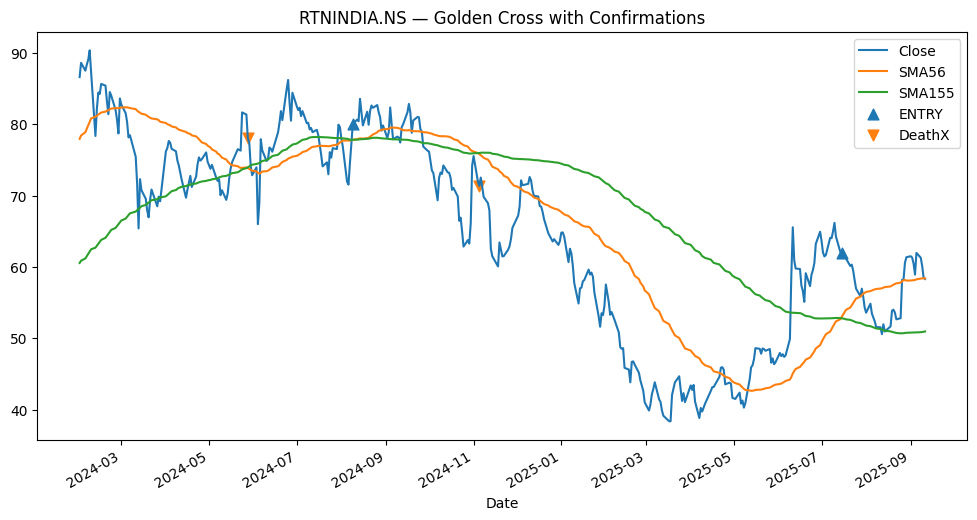

In [20]:
# =========================
# Plot Helper (single ticker)
# =========================
def plot_ticker(ticker, params=None, last_n=400):
    df = data[ticker].copy()
    p = params or best_by_ticker[ticker]
    edf = enrich(df, p)
    sig = generate_signals(edf, p)

    fig, ax = plt.subplots(figsize=(12,6))
    edf["Close"].tail(last_n).plot(ax=ax, label="Close")
    edf["SMA_S"].tail(last_n).plot(ax=ax, label=f"SMA{p['sma_short']}")
    edf["SMA_L"].tail(last_n).plot(ax=ax, label=f"SMA{p['sma_long']}")
    # mark entries
    eidx = sig.index[sig["ENTRY"]].intersection(edf.index[-last_n:])
    ax.scatter(eidx, edf.loc[eidx, "Close"], marker="^", s=60, label="ENTRY")
    didx = sig.index[sig["DC"]].intersection(edf.index[-last_n:])
    ax.scatter(didx, edf.loc[didx, "Close"], marker="v", s=60, label="DeathX")
    ax.set_title(f"{ticker} — Golden Cross with Confirmations")
    ax.legend()
    plt.show()

# Example (uncomment to plot):
plot_ticker(best_ticker)


In [21]:
# Show a compact table of best results per ticker
summary_rows = []
for r in results:
    bm = r["best_metrics"]
    summary_rows.append({
        "Ticker": r["ticker"],
        "Score": r["best_score"],
        "CAGR": bm["CAGR"],
        "Sharpe": bm["Sharpe"],
        "Sortino": bm["Sortino"],
        "MaxDD": bm["MaxDD"],
        "NumTrades": bm["NumTrades"],
        "WinRate": bm["WinRate"],
    })
summary_df = pd.DataFrame(summary_rows).sort_values(by="Score", ascending=False).reset_index(drop=True)
summary_df


,Ticker,Score,CAGR,Sharpe,Sortino,MaxDD,NumTrades,WinRate
0,RTNINDIA.NS,0.463433,0.463433,1.497891,2.742410,-0.529295,7,0.571429
1,AIIL.NS,0.402769,0.402769,1.743816,3.834786,-0.083364,1,1.000000
2,ALOKINDS.NS,0.308483,0.308483,0.372009,9.959922,-0.235474,6,0.666667
3,IRFC.NS,0.303229,0.303229,1.088407,2.279295,-0.218787,3,0.666667
4,PGEL.NS,0.280104,0.280104,1.187934,2.453599,-0.205215,2,1.000000
...,...,...,...,...,...,...,...,...
495,ETERNAL.NS,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000
496,PAGEIND.NS,-0.011257,-0.011257,-0.409086,-0.453039,-0.311681,2,1.000000
497,MRF.NS,-0.011922,-0.011922,-0.813245,-0.950561,-0.143286,2,1.000000
498,SHREECEM.NS,-0.077034,-0.077034,-0.809776,-0.814923,-0.413234,4,0.750000



# 📊 All-Tickers CSV Export (bounded) + Per-Trade CSV

This section creates two CSVs:

1. **`gc_all_params.csv`** — one row per *ticker* with best metrics/params and
   `confirmations_hit` (= union of confirmations that actually fired on entry bars).
2. **`gc_all_trades.csv`** — one row per *trade* with per-trade `confirmations_true`
   (only those that fired for that specific entry).

### Runtime Safeguards
- `MAX_TICKERS` limits the number of tickers processed.
- `MAX_PARAM_COMBOS` caps parameter combinations per ticker (random sampling from the grid).
- `MAX_SECONDS_PER_TICKER` stops optimizing a ticker if it takes too long.
- Clear progress prints help you monitor execution.


In [22]:

# ==== User Controls ====
tickers = globals().get("tickers") or globals().get("TICKERS") or [
    "HDFCBANK.NS","RELIANCE.NS","TCS.NS","INFY.NS","ICICIBANK.NS","LT.NS","AXISBANK.NS","SBIN.NS"
]

START = globals().get("START", "2015-01-01")
END   = globals().get("END",   None)  # None -> up to today

# Runtime bounds
MAX_TICKERS = 12               # limit how many tickers to process
MAX_PARAM_COMBOS = 120         # cap grid size per ticker
MAX_SECONDS_PER_TICKER = 60.0  # watchdog (seconds) per ticker

# Output paths
from pathlib import Path
OUT_PARAMS_CSV = Path("output/gc_all_params.csv")
OUT_TRADES_CSV = Path("output/gc_all_trades.csv")

# ==== Imports ====
import time
import math
import random
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings("ignore")

try:
    import yfinance as yf
except Exception as e:
    raise RuntimeError("Please install yfinance: pip install yfinance") from e

try:
    import talib as ta
    HAVE_TALIB = True
except Exception:
    HAVE_TALIB = False

# ---------- Indicator helpers ----------
def sma(series: pd.Series, n: int) -> pd.Series:
    return series.rolling(n, min_periods=n).mean()

def macd_core(close: pd.Series, fast=12, slow=26, signal=9):
    if HAVE_TALIB:
        macd, macdsig, macdhist = ta.MACD(close, fastperiod=fast, slowperiod=slow, signalperiod=signal)
        return macd, macdsig, macdhist
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macdsig = macd.ewm(span=signal, adjust=False).mean()
    macdhist = macd - macdsig
    return macd, macdsig, macdhist

def rsi_core(close: pd.Series, n=14):
    if HAVE_TALIB:
        return ta.RSI(close, timeperiod=n)
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(n).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(n).mean()
    rs = gain / (loss.replace(0, np.nan))
    out = 100 - (100 / (1 + rs))
    return out

def adx_core(high: pd.Series, low: pd.Series, close: pd.Series, n=14):
    if HAVE_TALIB:
        return ta.ADX(high, low, close, timeperiod=n)
    plus_dm = (high.diff()).clip(lower=0)
    minus_dm = (-low.diff()).clip(lower=0)
    tr = pd.concat([
        (high - low),
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(n).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/n, adjust=False).mean() / atr)
    minus_di = 100 * (minus_dm.ewm(alpha=1/n, adjust=False).mean() / atr)
    dx = (100 * (plus_di - minus_di).abs() / (plus_di + minus_di))
    adx = dx.ewm(alpha=1/n, adjust=False).mean()
    return adx

def stochrsi_core(close: pd.Series, rsi_n=14, stoch_n=14, k=3, d=3):
    r = rsi_core(close, n=rsi_n)
    ll = r.rolling(stoch_n).min()
    hh = r.rolling(stoch_n).max()
    stoch = 100 * (r - ll) / (hh - ll)
    k_line = stoch.rolling(k).mean()
    d_line = k_line.rolling(d).mean()
    return k_line, d_line

def cci_core(high: pd.Series, low: pd.Series, close: pd.Series, n=20):
    if HAVE_TALIB:
        return ta.CCI(high, low, close, timeperiod=n)
    tp = (high + low + close) / 3.0
    sma_tp = tp.rolling(n).mean()
    mad = (tp - sma_tp).abs().rolling(n).mean()
    cci = (tp - sma_tp) / (0.015 * mad)
    return cci

def atr_core(high: pd.Series, low: pd.Series, close: pd.Series, n=14):
    if HAVE_TALIB:
        return ta.ATR(high, low, close, timeperiod=n)
    tr = pd.concat([
        (high - low),
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(n).mean()

# ---------- Parameter search space ----------
PARAM_GRID = {
    "sma_short": [50, 74],
    "sma_long": [150, 153, 200],
    "slope_win": [10, 20],
    "macd_fast": [11, 12],
    "macd_slow": [21, 26],
    "macd_signal": [9, 11],
    "rsi_n": [9, 14],
    "rsi_buy_min": [40, 42],
    "rsi_buy_max": [60, 65],
    "adx_n": [14, 17],
    "adx_min": [20, 25],
    "srsi_rsi_n": [13, 14],
    "srsi_stoch_n": [13, 14],
    "srsi_k": [3],
    "srsi_d": [3],
    "srsi_upper": [80, 83],
    "cci_n": [20, 26],
    "cci_min": [40, 46],
    "atr_n": [14, 16],
    "vol_rank_win": [20, 24],
    "vol_pct_min": [0.5, 0.525],
    "use_atr_trail": [False],
    "atr_mult": [1.34],
    "stop_loss_pct": [None],
    "take_profit_pct": [0.1],
    "max_hold": [58],
    "confirmations": [["MACD","RSI","ADX","STOCHRSI","CCI","SLOPE","VOLUME"]],
    "confirm_mode": ["k-of-n"],
    "confirm_k": [2],
}

from itertools import product
def all_param_combos(grid: Dict[str, List]):
    keys = list(grid.keys())
    base = [grid[k] for k in keys]
    for vals in product(*base):
        yield dict(zip(keys, vals))

def sample_param_combos(grid: Dict[str, List], k: int):
    # naive uniform sampling from the full Cartesian product (bounded)
    all_list = list(all_param_combos(grid))
    if len(all_list) <= k:
        return all_list
    return random.sample(all_list, k)

# ---------- Confirmations ----------
def confirmation_signals(df: pd.DataFrame, i: int, p: dict) -> Dict[str, bool]:
    out = {}
    out["MACD"] = bool(df.loc[df.index[i], "MACD"] > df.loc[df.index[i], "MACDsig"])
    rsi_v = df.loc[df.index[i], "RSI"]
    out["RSI"] = bool((rsi_v >= p["rsi_buy_min"]) and (rsi_v <= p["rsi_buy_max"]))
    out["ADX"] = bool(df.loc[df.index[i], "ADX"] >= p["adx_min"])
    out["STOCHRSI"] = bool((df.loc[df.index[i], "SRSI_K"] > df.loc[df.index[i], "SRSI_D"]) and (df.loc[df.index[i], "SRSI_K"] < p["srsi_upper"]))
    out["CCI"] = bool(df.loc[df.index[i], "CCI"] >= p["cci_min"])
    if p["slope_win"] > 1 and i - p["slope_win"] >= 0:
        prev = df["SMA_short"].iloc[i - p["slope_win"]]
        cur  = df["SMA_short"].iloc[i]
        out["SLOPE"] = bool(cur > prev)
    else:
        out["SLOPE"] = False
    win = int(p["vol_rank_win"])
    if win > 1 and i - win + 1 >= 0:
        seg = df["Volume"].iloc[i - win + 1 : i + 1]
        rank = (seg.rank(pct=True).iloc[-1])
        out["VOLUME"] = bool(rank >= p["vol_pct_min"])
    else:
        out["VOLUME"] = False
    return out

def passes_conf(out_map: Dict[str,bool], names: List[str], mode: str, k: int):
    vals = [(n, bool(out_map.get(n, False))) for n in names]
    names_true = [n for n,v in vals if v]
    if mode == "all-of-n":
        return (len(names_true) == len(names), names_true)
    return (len(names_true) >= max(1, min(k, len(names))), names_true)

# ---------- Backtest ----------
def backtest_gc(df: pd.DataFrame, p: dict):
    df = df.copy()
    df["SMA_short"] = sma(df["Close"], p["sma_short"])
    df["SMA_long"]  = sma(df["Close"], p["sma_long"])
    df["MACD"], df["MACDsig"], df["MACDhist"] = macd_core(df["Close"], p["macd_fast"], p["macd_slow"], p["macd_signal"])
    df["RSI"] = rsi_core(df["Close"], p["rsi_n"])
    df["ADX"] = adx_core(df["High"], df["Low"], df["Close"], p["adx_n"])
    df["SRSI_K"], df["SRSI_D"] = stochrsi_core(df["Close"], p["srsi_rsi_n"], p["srsi_stoch_n"], p["srsi_k"], p["srsi_d"])
    df["CCI"] = cci_core(df["High"], df["Low"], df["Close"], p["cci_n"])
    df["ATR"] = atr_core(df["High"], df["Low"], df["Close"], p["atr_n"])

    trades = []
    in_pos = False
    entry_px = None
    entry_i = None
    entry_conf_names = None

    for i in range(1, len(df)):
        cross_up = (df["SMA_short"].iloc[i-1] <= df["SMA_long"].iloc[i-1]) and (df["SMA_short"].iloc[i] > df["SMA_long"].iloc[i])
        if (not in_pos) and cross_up:
            conf_map = confirmation_signals(df, i, p)
            ok, names_true = passes_conf(conf_map, p["confirmations"], p["confirm_mode"], p["confirm_k"])
            if ok:
                in_pos = True
                entry_px = float(df["Open"].iloc[i+1] if i+1 < len(df) else df["Close"].iloc[i])
                entry_i  = i
                entry_conf_names = names_true

        if in_pos:
            exit_reasons = []
            if p["take_profit_pct"] is not None and entry_px is not None:
                if (df["High"].iloc[i] / entry_px - 1.0) >= p["take_profit_pct"]:
                    exit_reasons.append("TP")
            if p["stop_loss_pct"] is not None and entry_px is not None:
                if (df["Low"].iloc[i] / entry_px - 1.0) <= -abs(p["stop_loss_pct"]):
                    exit_reasons.append("SL")
            death = (df["SMA_short"].iloc[i-1] >= df["SMA_long"].iloc[i-1]) and (df["SMA_short"].iloc[i] < df["SMA_long"].iloc[i])
            if death:
                exit_reasons.append("DeathCross")
            if (p["max_hold"] is not None) and (i - entry_i >= p["max_hold"]):
                exit_reasons.append("MaxHold")

            if exit_reasons:
                exit_px = float(df["Open"].iloc[i+1] if i+1 < len(df) else df["Close"].iloc[i])
                trades.append({
                    "entry_idx": entry_i,
                    "exit_idx": i,
                    "entry_date": df.index[entry_i],
                    "exit_date": df.index[i],
                    "entry_px": entry_px,
                    "exit_px": exit_px,
                    "ret": (exit_px / entry_px - 1.0),
                    "confirmations_true": entry_conf_names or [],
                    "exit_reason": "+".join(exit_reasons)
                })
                in_pos = False
                entry_px = None
                entry_i = None
                entry_conf_names = None

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        metrics = dict(
            total_return=0.0, CAGR=0.0, Sharpe=0.0, Sortino=0.0,
            MaxDD=0.0, WinRate=0.0, NumTrades=0
        )
        return trades_df, metrics

    # Equity curve (approx)
    trades_df["equity"] = (1.0 + trades_df["ret"]).cumprod()
    total_return = trades_df["equity"].iloc[-1] - 1.0

    # Daily returns approx for Sharpe/Sortino
    eq = pd.Series(1.0, index=df.index)
    for _, t in trades_df.iterrows():
        eq.loc[t["entry_date"]:t["exit_date"]] = eq.loc[t["entry_date"]:t["exit_date"]].iloc[0] * (1.0 + t["ret"])
    daily_ret = eq.pct_change().dropna()
    if daily_ret.empty:
        sharpe = 0.0; sortino = 0.0
    else:
        sharpe = (daily_ret.mean() / (daily_ret.std() + 1e-12)) * np.sqrt(252)
        downside = daily_ret[daily_ret < 0]
        sortino = (daily_ret.mean() / (downside.std() + 1e-12)) * np.sqrt(252)

    roll_max = eq.cummax()
    dd = eq/roll_max - 1.0
    maxdd = dd.min()

    years = (df.index[-1] - df.index[0]).days / 365.25
    CAGR = (1.0 + total_return) ** (1/years) - 1.0 if years > 0 else 0.0
    winrate = (trades_df["ret"] > 0).mean() if len(trades_df) else 0.0

    metrics = dict(
        total_return=float(total_return),
        CAGR=float(CAGR),
        Sharpe=float(sharpe),
        Sortino=float(sortino),
        MaxDD=float(maxdd),
        WinRate=float(winrate),
        NumTrades=int(len(trades_df)),
    )
    return trades_df, metrics

# ---------- Optimize per ticker with bounds ----------
def optimize_ticker(ticker: str):
    print(f"\n[+] Starting {ticker}")
    t0 = time.time()
    df = yf.download(ticker, start=START, end=END, progress=False, multi_level_index=False)
    if df is None or df.empty:
        print(f"[!] No data for {ticker}")
        return {}, {"total_return":0, "CAGR":0, "Sharpe":0, "Sortino":0, "MaxDD":0, "WinRate":0, "NumTrades":0}, pd.DataFrame()
    df = df.dropna().copy()

    # bounded param sampling
    combos = sample_param_combos(PARAM_GRID, MAX_PARAM_COMBOS)
    best = None
    best_metrics = None
    best_score = -1e18

    for idx, p in enumerate(combos, 1):
        if time.time() - t0 > MAX_SECONDS_PER_TICKER:
            print(f"[~] Watchdog hit for {ticker}; stopping at {idx-1} combos")
            break
        if p["sma_short"] >= p["sma_long"]:
            continue
        trades, metrics = backtest_gc(df, p)
        score = metrics["CAGR"]
        if score > best_score:
            best = p
            best_metrics = metrics
            best_score = score
        if idx % 20 == 0:
            print(f"  ...{ticker}: tested {idx} combos; current best CAGR={best_score:.4f}")

    if best is None:
        print(f"[!] No valid params for {ticker}")
        return {}, {"total_return":0, "CAGR":0, "Sharpe":0, "Sortino":0, "MaxDD":0, "WinRate":0, "NumTrades":0}, pd.DataFrame()

    # Recompute for best to collect union of confirmations across entries
    trades, _ = backtest_gc(df, best)
    union_hit = set()
    for _, row in trades.iterrows():
        for name in (row.get("confirmations_true") or []):
            union_hit.add(name)
    best = dict(best)
    best["confirmations_hit"] = sorted(list(union_hit))
    print(f"[✓] Finished {ticker}. CAGR={best_metrics['CAGR']:.4f}, trades={best_metrics['NumTrades']}")

    # Attach ticker to trades and stringify confirmations per trade
    if not trades.empty:
        trades["ticker"] = ticker
        trades["confirmations_true"] = trades["confirmations_true"].apply(lambda lst: "|".join(lst) if isinstance(lst, list) else "")
    return best, best_metrics, trades

# ---------- Run loop and write CSVs ----------
rows = []
all_trades = []
for tk in tickers[:MAX_TICKERS]:
    params, metrics, trades_df = optimize_ticker(tk)
    if params:
        row = {
            "ticker": tk,
            "score": metrics["CAGR"],
            **metrics,
            "sma_short": params.get("sma_short"),
            "sma_long": params.get("sma_long"),
            "slope_win": params.get("slope_win"),
            "macd_fast": params.get("macd_fast"),
            "macd_slow": params.get("macd_slow"),
            "macd_signal": params.get("macd_signal"),
            "rsi_n": params.get("rsi_n"),
            "rsi_buy_min": params.get("rsi_buy_min"),
            "rsi_buy_max": params.get("rsi_buy_max"),
            "adx_n": params.get("adx_n"),
            "adx_min": params.get("adx_min"),
            "srsi_rsi_n": params.get("srsi_rsi_n"),
            "srsi_stoch_n": params.get("srsi_stoch_n"),
            "srsi_k": params.get("srsi_k"),
            "srsi_d": params.get("srsi_d"),
            "srsi_upper": params.get("srsi_upper"),
            "cci_n": params.get("cci_n"),
            "cci_min": params.get("cci_min"),
            "atr_n": params.get("atr_n"),
            "vol_rank_win": params.get("vol_rank_win"),
            "vol_pct_min": params.get("vol_pct_min"),
            "use_atr_trail": params.get("use_atr_trail"),
            "atr_mult": params.get("atr_mult"),
            "stop_loss_pct": params.get("stop_loss_pct"),
            "take_profit_pct": params.get("take_profit_pct"),
            "max_hold": params.get("max_hold"),
            "confirm_mode": params.get("confirm_mode"),
            "confirm_k": params.get("confirm_k"),
            "confirmations_hit": "|".join(params.get("confirmations_hit", [])),
        }
        rows.append(row)
    if trades_df is not None and not trades_df.empty:
        all_trades.append(trades_df)

# Save CSVs
params_df = pd.DataFrame(rows).sort_values(by="score", ascending=False)
params_df.to_csv(OUT_PARAMS_CSV, index=False)

if len(all_trades):
    trades_df = pd.concat(all_trades, ignore_index=True)
else:
    trades_df = pd.DataFrame(columns=[
        "ticker","entry_date","exit_date","entry_px","exit_px","ret","exit_reason","confirmations_true"
    ])
trades_df.to_csv(OUT_TRADES_CSV, index=False)

print(f"\n[Output] Saved params to {OUT_PARAMS_CSV.resolve()} and trades to {OUT_TRADES_CSV.resolve()}")
print("[Hint] If you want to process more tickers/combinations, increase MAX_TICKERS/MAX_PARAM_COMBOS or relax the watchdog.")



[+] Starting EXIDEIND.NS
  ...EXIDEIND.NS: tested 20 combos; current best CAGR=0.0394
  ...EXIDEIND.NS: tested 40 combos; current best CAGR=0.0394
  ...EXIDEIND.NS: tested 60 combos; current best CAGR=0.0394
  ...EXIDEIND.NS: tested 80 combos; current best CAGR=0.0394
  ...EXIDEIND.NS: tested 100 combos; current best CAGR=0.0394
  ...EXIDEIND.NS: tested 120 combos; current best CAGR=0.0394
[✓] Finished EXIDEIND.NS. CAGR=0.0394, trades=4

[Output] Saved params to /Users/hemank/Documents/github/trading/swing/Golden Crossover/output/gc_all_params.csv and trades to /Users/hemank/Documents/github/trading/swing/Golden Crossover/output/gc_all_trades.csv
[Hint] If you want to process more tickers/combinations, increase MAX_TICKERS/MAX_PARAM_COMBOS or relax the watchdog.
